# 04_trees_model_example


<a name='index'></a>

# Contents of this notebook


1. <a href=#cats>Consolidate Project Categories</a>


2. <a href=#subset>Subset and scale data for `X` and `y` frames</a>


3. <a href=#fit>**Fit boosted tree models using sklearn `AdaBoostRegressor` and `generate_model_dict()` function**</a>


4. <a href=#plot>**Plot predictions against true `y` values**</a>

    - <a href=#plot1>**Version 1:** using the generate model dictionary directly</a>
    
    - <a href=#plot2>**Version 2:** extracting predictions from 2 model dicts and plotting together</a>
    


5. <a href=#results>**Examine the effects of `max_depth` and number of iterations on our results**</a>


6. <a href=#findings>**Findings (WE CAN ACHIEVE A HIGHER $R^2$ WITH ADABOOST!!!)**</a>

In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, \
                                  RobustScaler, LabelEncoder

# import custom .py functions from src/ directory 
sys.path.append('..')
from src.datagen import print_interval_dict
from src.scale import scale_features, sigmoid, log_plus_one, encode_categories
from src.model import generate_model_dict, print_model_results
from src.visualize import plot_true_pred, plot_bdgt_sched_scaled, \
                          plot_change_trend


# Avoid scientific notation output in Pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '{:,.2f}'.format

# Improve resolution of output graphics
%config InlineBackend.figure_format ='retina'

In [2]:
file_path = '../data/interim/NYC_capital_projects_3yr.csv'
    
if os.path.isfile(file_path):
    print("OK - path points to file.")
else:
    print("ERROR - check the 'file_path' and ensure it points to the source file.")

OK - path points to file.


In [3]:
data = pd.read_csv(file_path)
data_full = pd.read_csv('../data/interim/Capital_Projects_clean.csv') 

In [4]:
# entries
print(f"Number of dataset records: {len(data)}")

# num projects
print(f"Number of unique projects in dataset: {len(data['PID'].unique())}")

Number of dataset records: 149
Number of unique projects in dataset: 149


In [5]:
datetime_cols = [
    'Design_Start',
    'Final_Change_Date',
    'Schedule_Start',
    'Schedule_End',
]

for col in datetime_cols:
    data[col] = pd.to_datetime(data[col])

In [6]:
data.info()

data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   PID                    149 non-null    int64         
 1   Project_Name           149 non-null    object        
 2   Description            149 non-null    object        
 3   Category               149 non-null    object        
 4   Borough                149 non-null    object        
 5   Managing_Agency        149 non-null    object        
 6   Client_Agency          149 non-null    object        
 7   Phase_Start            149 non-null    object        
 8   Current_Project_Years  149 non-null    float64       
 9   Current_Project_Year   149 non-null    int64         
 10  Design_Start           149 non-null    datetime64[ns]
 11  Budget_Start           149 non-null    float64       
 12  Schedule_Start         149 non-null    datetime64[ns]
 13  Final

,PID,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Phase_Start,Current_Project_Years,Current_Project_Year,...,Schedule_Change,Budget_Change,Schedule_Change_Ratio,Budget_Change_Ratio,Budget_Abs_Per_Error,Budget_Rel_Per_Error,Duration_End_Ratio,Budget_End_Ratio,Duration_Ratio_Inv,Budget_Ratio_Inv
0,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,2-Design,5.94,6,...,91,"-15,619,967.29",0.04,-0.08,0.09,0.08,1.04,0.92,-0.04,0.09
1,7,Bowery Bay Waste Water Treatment Plant Main Se...,The existing Main Sewage Pumps have deteriorat...,Wastewater Treatment,Queens,DEP,DEP,2-Design,6.34,7,...,334,"9,618,785.30",0.19,0.18,0.15,0.18,1.19,1.18,-0.16,-0.15
2,91,Mill Basin Bridge Replacement,Complete replacement of bascule bridge with a ...,Bridges,Brooklyn,DOT,not_specified,2-Design,7.44,8,...,247,"-34,672,662.00",0.09,-0.09,0.10,0.09,1.09,0.91,-0.08,0.10


<a name='cats'></a>

# Consolidate Project Categories

<a href=#index>Index</a>

In [7]:
print(
    'The original {} project categories and assocated project counts:\n\n'\
    '{}\n\n'.format(
        data['Category'].nunique(),
        data['Category'].value_counts()
    )
)

rename_cat_dict = {
    'Bridges, Streets and Roadways': 'Bridges',
    'Parks, Streets and Roadways': 'Parks',
    'Industrial Development, Parks': 'Industrial Development',
    'Other Government Facilities': 'Other Govt Facilities and Improvements',
    'Public Safety and Criminal Justice': 'Other Govt Facilities and Improvements',
    'Arts and Culture': 'Other Govt Facilities and Improvements',
    'Health and Hospitals': 'Other Govt Facilities and Improvements',
}

data['Category'] = data['Category'].copy().map(rename_cat_dict).fillna(data['Category'])

print(
    'The newly mapped {} project categories and project counts:\n\n'\
    '{}\n'.format(
        data['Category'].nunique(),
        data['Category'].value_counts()
    )
)

The original 17 project categories and assocated project counts:

Streets and Roadways                  31
Sewers                                20
Schools                               15
Industrial Development                15
Water Supply                          13
Wastewater Treatment                  13
Bridges, Streets and Roadways          9
Bridges                                7
Sanitation                             6
Other Government Facilities            4
Public Safety and Criminal Justice     4
Ferries                                3
Health and Hospitals                   3
Parks                                  2
Arts and Culture                       2
Parks, Streets and Roadways            1
Industrial Development, Parks          1
Name: Category, dtype: int64


The newly mapped 11 project categories and project counts:

Streets and Roadways                      31
Sewers                                    20
Bridges                                   16
Industrial 

<a name='subset'></a>

# Subset and scale data for X and y frames

<a href=#index>Index</a>

In [8]:
X_cols = [
    'Budget_Start',
    'Duration_Start',
    'Category'
]

y_cols = [
    'Budget_Change_Ratio',
    'Schedule_Change_Ratio'
]


In [9]:
X, y = data[X_cols], data[y_cols]

In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Budget_Start    149 non-null    float64
 1   Duration_Start  149 non-null    int64  
 2   Category        149 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.6+ KB


In [11]:
# One hot encode categorical variables
drop_cat = 'Other Govt Facilities and Improvements'
one_hot = True

X_ohe = encode_categories(
    X, colname='Category',
    one_hot=one_hot,
    drop_cat=drop_cat,
    drop_original_col=True
)

X_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Budget_Start            149 non-null    float64
 1   Duration_Start          149 non-null    int64  
 2   Bridges                 149 non-null    uint8  
 3   Ferries                 149 non-null    uint8  
 4   Industrial_Development  149 non-null    uint8  
 5   Parks                   149 non-null    uint8  
 6   Sanitation              149 non-null    uint8  
 7   Schools                 149 non-null    uint8  
 8   Sewers                  149 non-null    uint8  
 9   Streets_and_Roadways    149 non-null    uint8  
 10  Wastewater_Treatment    149 non-null    uint8  
 11  Water_Supply            149 non-null    uint8  
dtypes: float64(1), int64(1), uint8(10)
memory usage: 3.9 KB


In [12]:
# label encode categorical variables
drop_cat = 'Other Govt Facilities and Improvements'
one_hot = False

X_le = encode_categories(
    X, colname='Category',
    one_hot=one_hot,
    drop_cat=drop_cat,
    drop_original_col=True
)

X_le.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Budget_Start    149 non-null    float64
 1   Duration_Start  149 non-null    int64  
 2   Category_Code   149 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 3.6 KB


In [13]:
random_state = 109
test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(
    X_ohe, y,
    test_size=test_size,
    random_state=random_state,
    shuffle=True
)

X_le_tr, X_le_te, y_train, y_test = train_test_split(
    X_le, y,
    test_size=test_size,
    random_state=random_state,
    shuffle=True
)

In [14]:
print('{}\t{}'.format(X_train.shape, y_train.shape))
print('{}\t{}'.format(X_test.shape, y_test.shape))

(134, 12)	(134, 2)
(15, 12)	(15, 2)


In [15]:
#######################################
# CREATE SCALED DATAFRAMES
#######################################

# Identify binary variable columns to exclude from scaling
exclude_scale_cols = list(X)[2:]

# # Reset y dataframe indices or else we will run into indexing issues
# y_train = y_train.reset_index(drop=True)
# y_test = y_test.reset_index(drop=True)


# Standardize both X_train and X_test data, fitting X_train as the
# scaler for both
scaler = StandardScaler
scale_before_func = None
scale_after_func = None
reapply_scaler = False


X_train_std, Scaler_std = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

X_test_std, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)


# Standardize X_train and X_test, pass through sigmoid transformation
# and re-standardize to minimize skew of data
scaler = StandardScaler
scale_before_func = None
scale_after_func = sigmoid
reapply_scaler = True


X_train_std_sig, Scaler_std_sig = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

X_test_std_sig, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

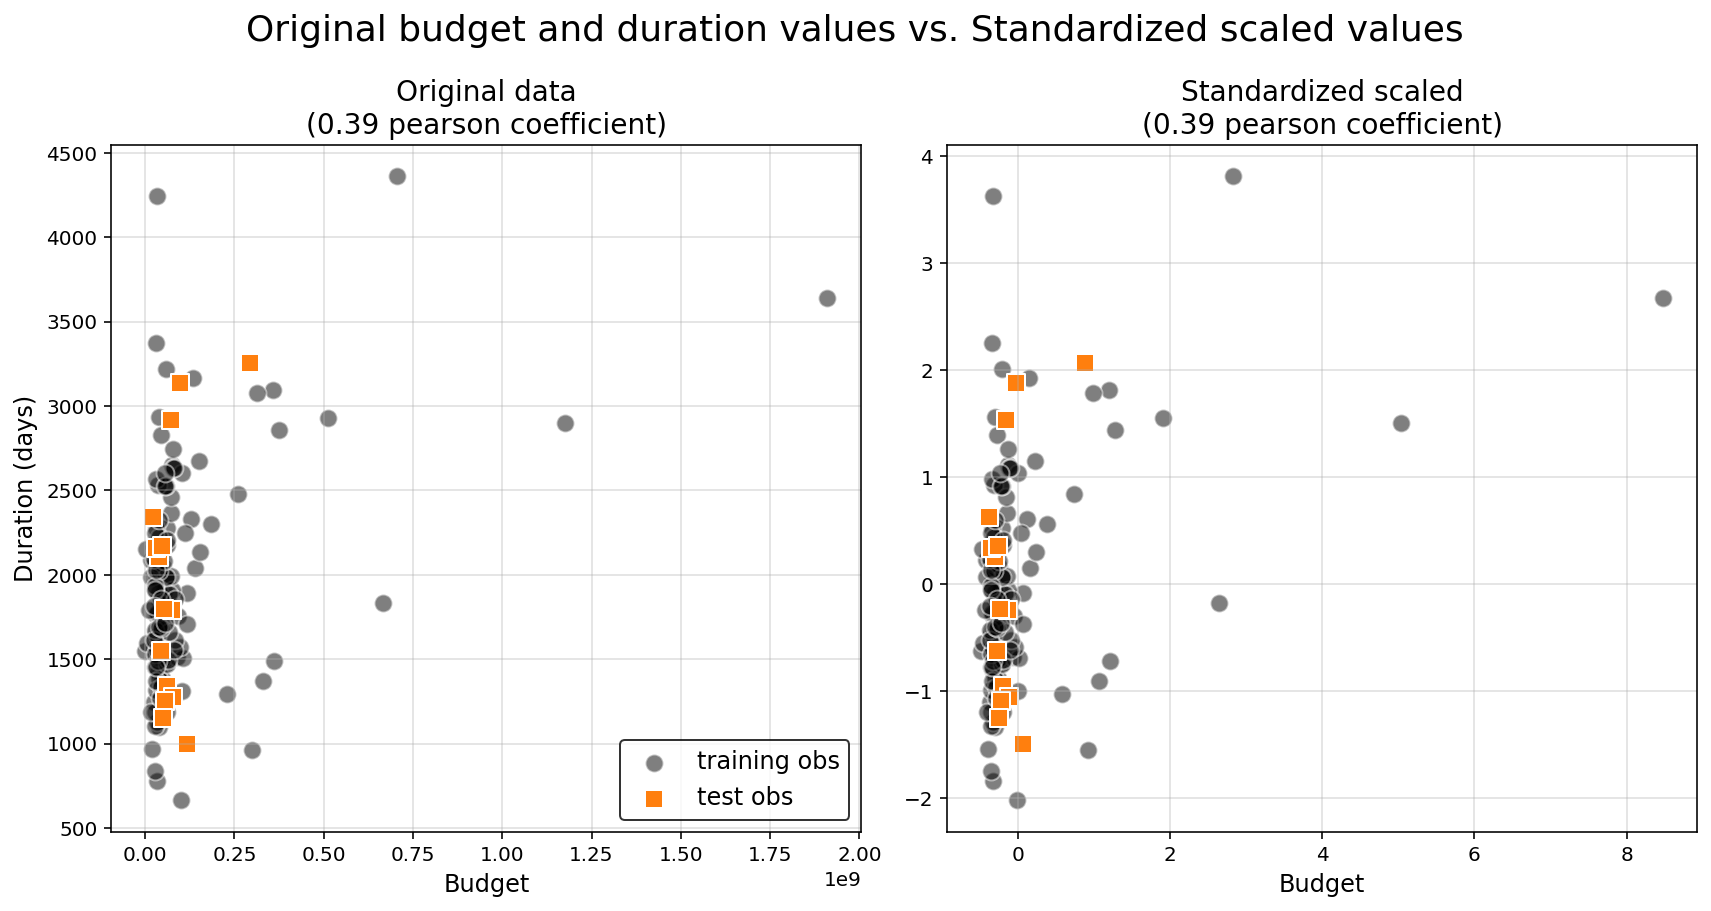

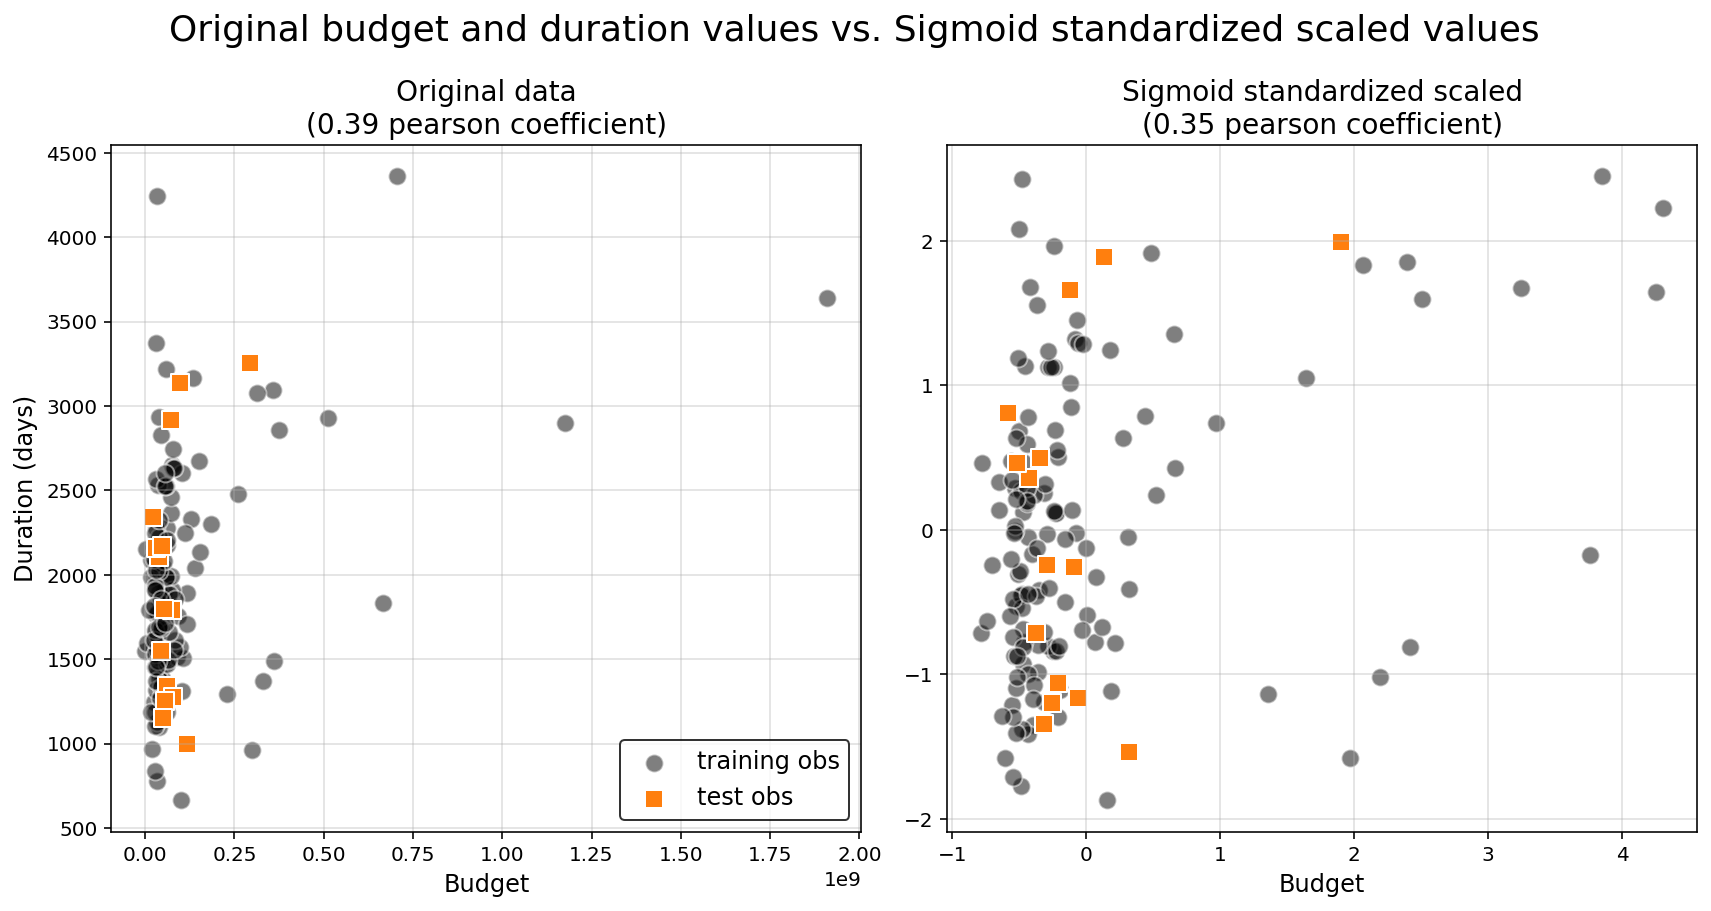

In [16]:
# inspect scaled datasets
plot_bdgt_sched_scaled(X_train, X_train_std, 'Standardized', X_test, X_test_std)
plot_bdgt_sched_scaled(X_train, X_train_std_sig, 'Sigmoid standardized', X_test, X_test_std_sig)

<a name='fit'></a>

# Fit boosted tree models using sklearn AdaBoostRegressor and `generate_model_dict()` function


<a href=#index>Index</a>

#### NOTE:

- I fit two versions of the model below.


- It appears that sometimes, depending on the random state that is set, the standardized sigmoid scaled data sometimes produces a better result for the `Budget_Change_Ratio` predictions  (but not always), while the unscaled data typically produces the best `Schedule_Change_Ratio` results.


- For illustrative purposes, I produce two versions of the model, one with each set of training data. However, in practice, I think we'll want to just use the unscaled data for our boosted tree model.

In [17]:
%%time

features = list(X_train)

model_descr = 'AdaBoost tree ensemble sigmoid scaled data'

# set parameters for AdaBoostRegressor model object
max_depth = 3
learning_rate = 0.05
n_estimators = 100
random_state = 109


model_ada_sigscaled = generate_model_dict(
    AdaBoostRegressor,
    model_descr,
    X_train_std_sig[features], X_test_std_sig[features], y_train, y_test,
    multioutput=False,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn',
    # these parameters below will be passed as *kwargs,
    # which means they will feed directly to the model object
    # when it is initialized
    base_estimator=DecisionTreeRegressor(
        max_depth=max_depth, random_state=random_state
    ),
    learning_rate = learning_rate,
    n_estimators = n_estimators,
    random_state=random_state
)

print_model_results(model_ada_sigscaled)


model_descr = 'AdaBoost tree ensemble unscaled data'

# set parameters for AdaBoostRegressor model object
max_depth = 3
learning_rate = 0.05
n_estimators = 20
random_state = 109


model_ada_unscaled = generate_model_dict(
    AdaBoostRegressor,
    model_descr,
    X_train[features], X_test[features], y_train, y_test,
    multioutput=False,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn',
    # these parameters below will be passed as *kwargs,
    # which means they will feed directly to the model object
    # when it is initialized
    base_estimator=DecisionTreeRegressor(
        max_depth=max_depth, random_state=random_state
    ),
    learning_rate = learning_rate,
    n_estimators = n_estimators,
    random_state=random_state
)

print_model_results(model_ada_unscaled)


MODEL SUMMARY:
AdaBoost tree ensemble sigmoid scaled data


The fitted model object(s):

	AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=109,
 

<a name='plot'></a>

# Plot predictions against true `y` values

<a href=#index>index</a>

<a name='plot1'></a>

## Version 1: Here I plot the results of one of the models by directly passing the one of the model dictionaries from above.

#### NOTE:

- I run the plotting function twice in the next cell. Once to show the 'train' results, once for the 'test' results

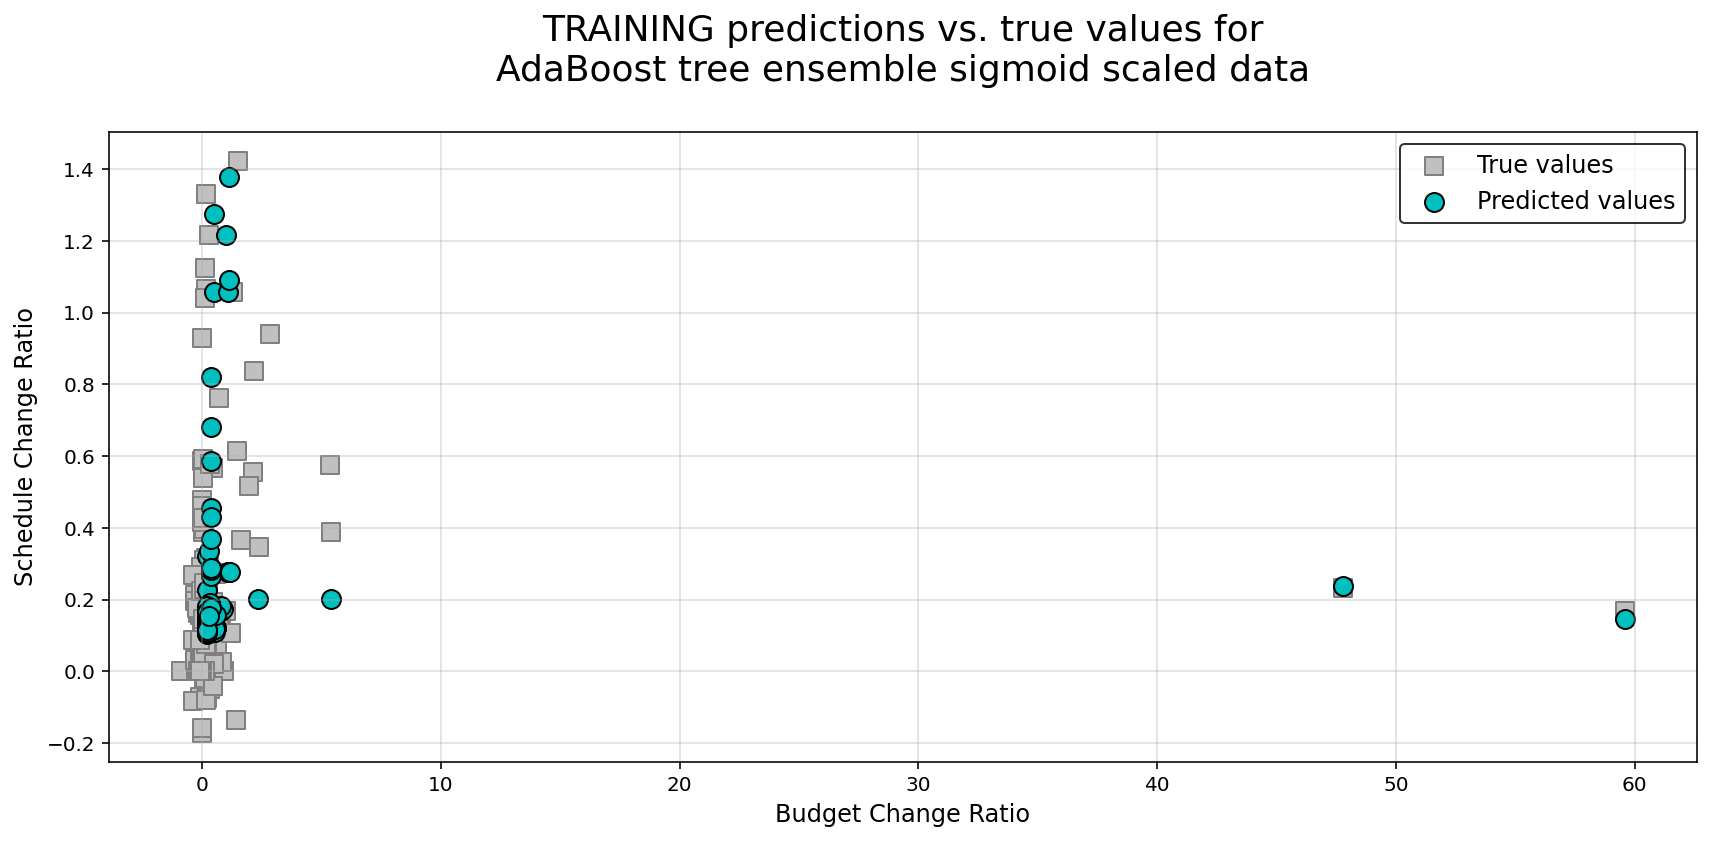

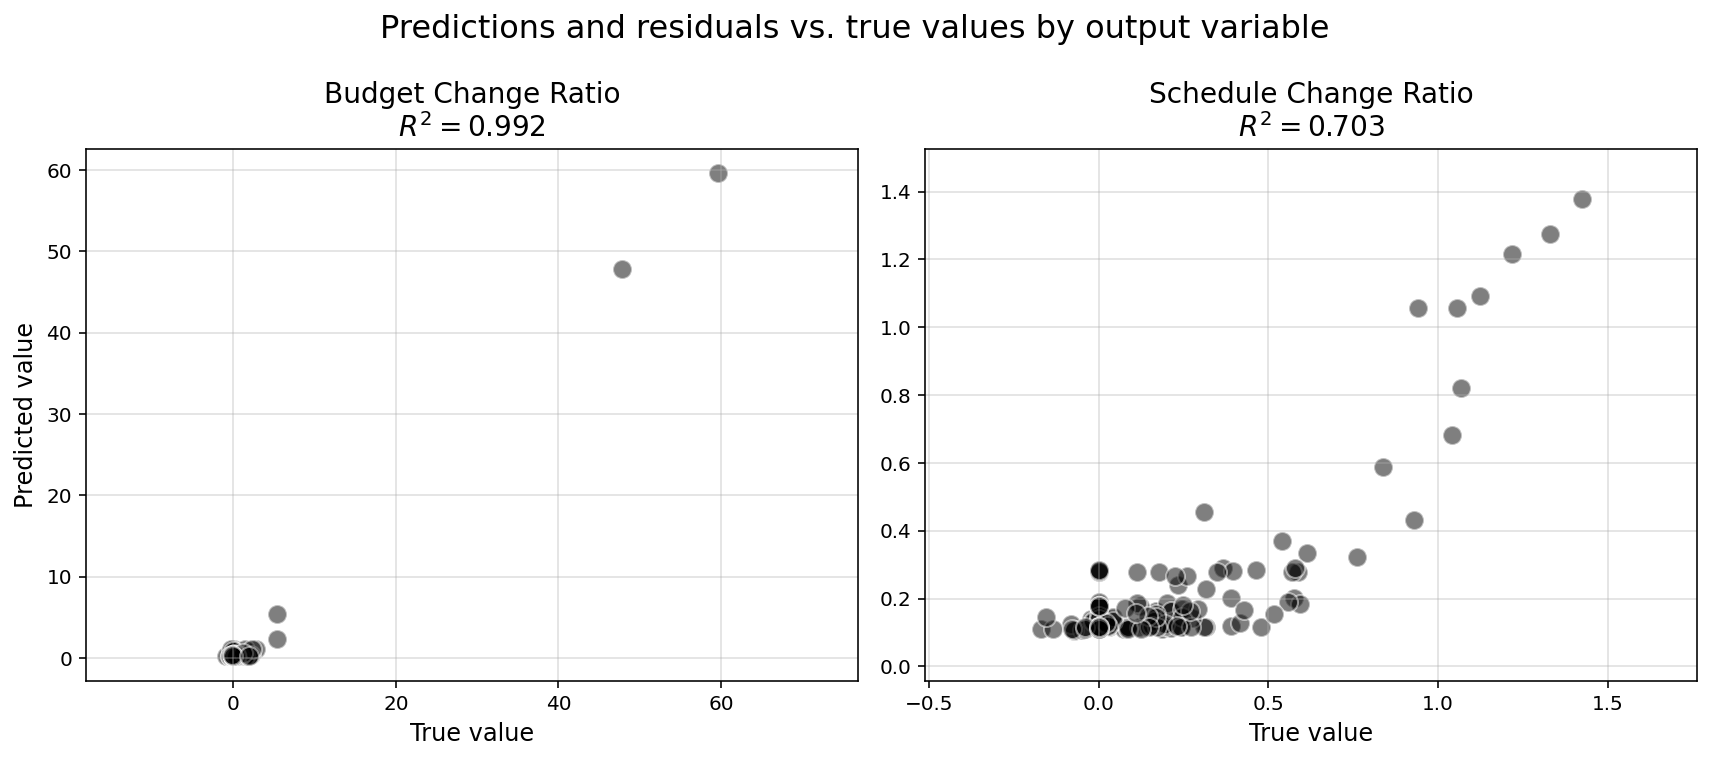

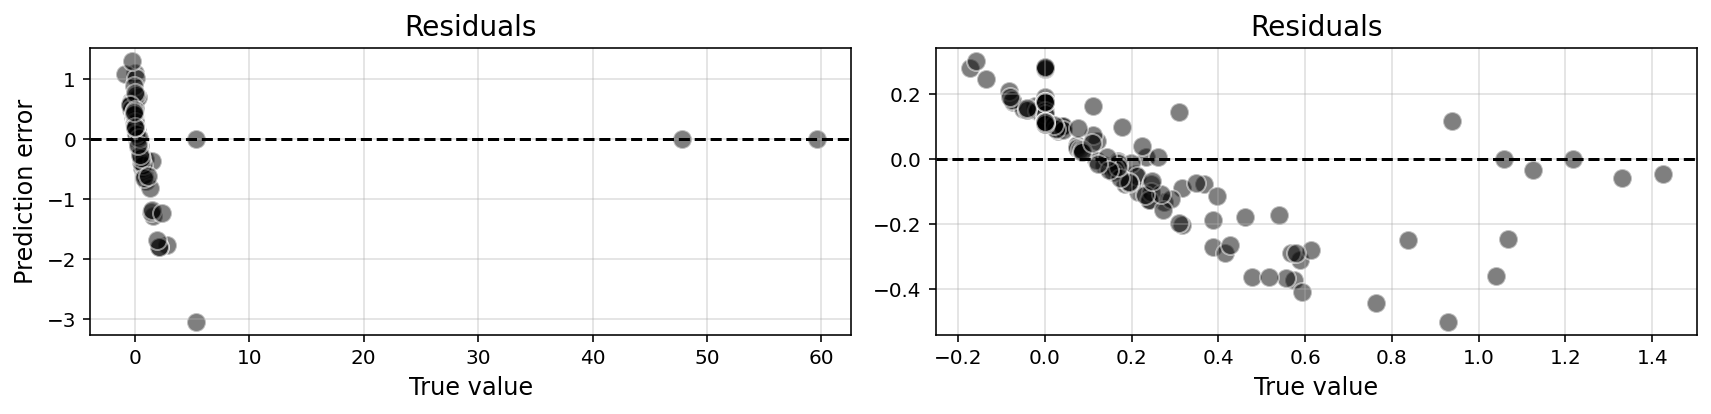

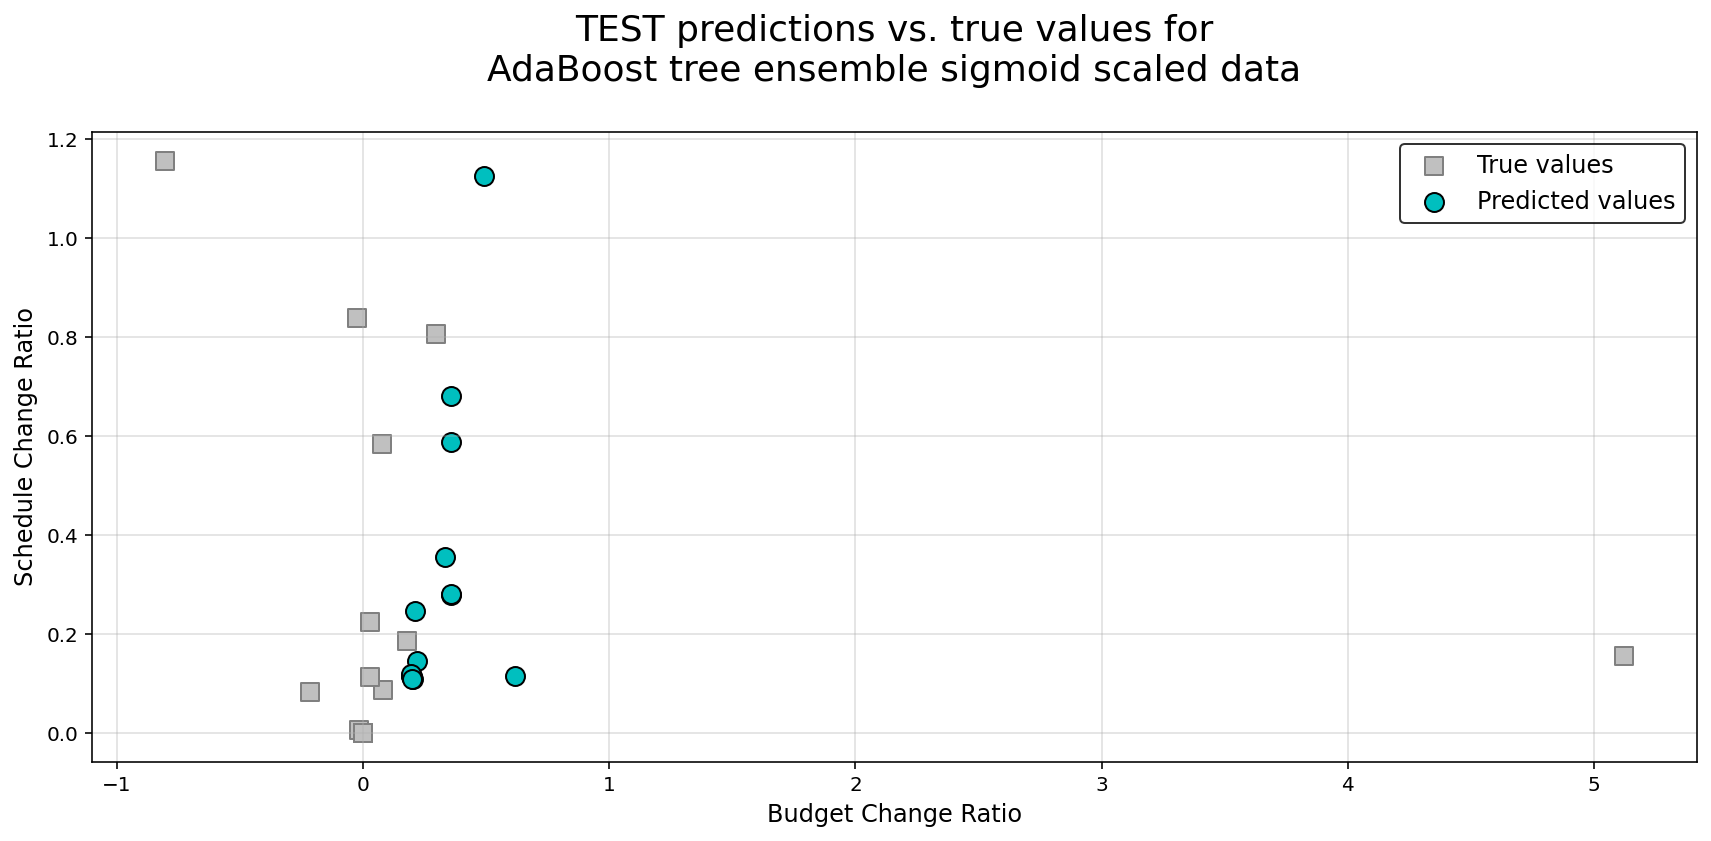

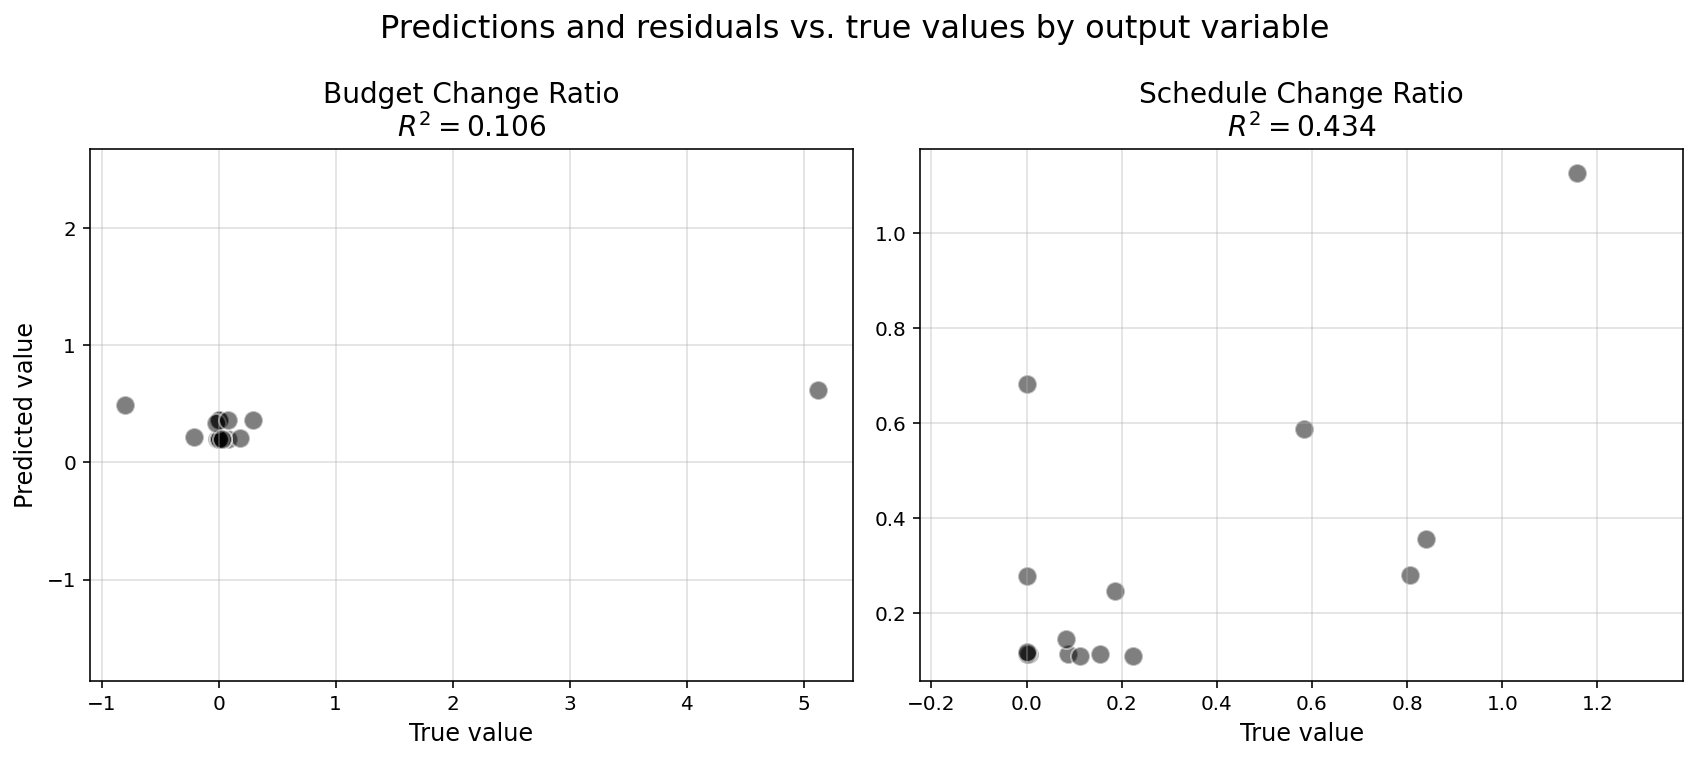

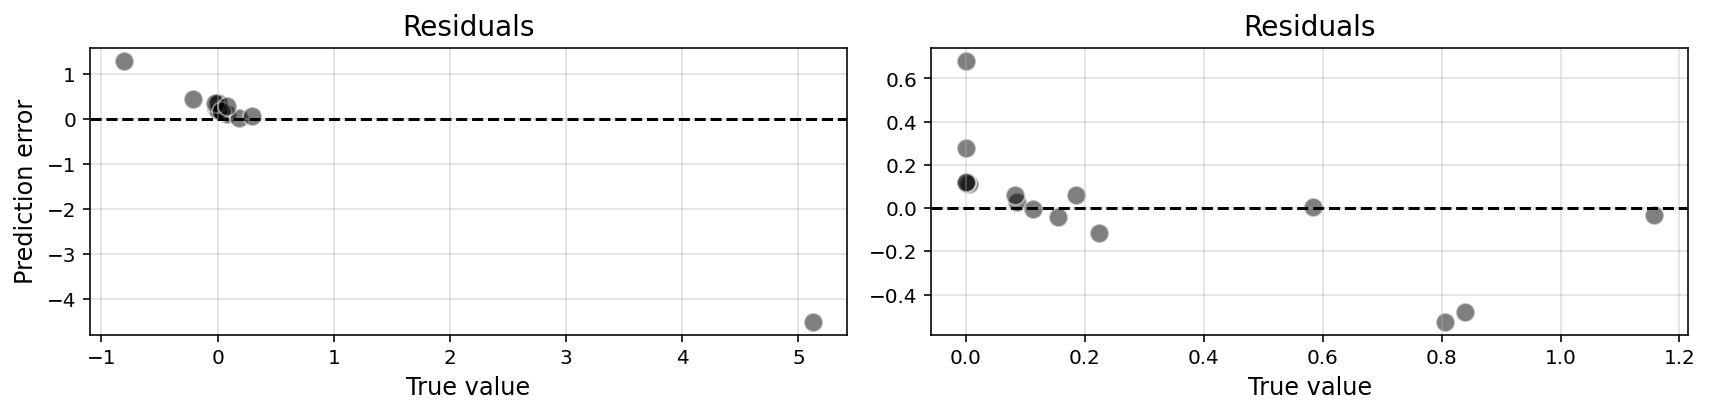

In [18]:
plot_true_pred(model_dict=model_ada_sigscaled, dataset='train')
plot_true_pred(model_dict=model_ada_sigscaled, dataset='test')

<a name='plot2'></a>

## Version 2: Here I extract a set of predictions from each model dict and plot them together

### Example: if I want to present the `Budget_Change_Ratio` results from the sigmoid scaled data model in the same plot as the `Schedule_Change_Ratio` results from the unscaled data model, I convert the desired predictions from each respective model dictionary into new prediction matrix and pass those to the plotting function instead, as such...

#### NOTE:

- By using the `y_true`, `y_pred`, `y1_label`, `y_label`, and `model_descr` arguments **instead** of the `model_dict` argument, I can these new matrices directly. 

In [19]:
y_pred_train = np.hstack(
    [
        model_ada_sigscaled['predictions']['train'][:, 0].reshape(-1,1),
        model_ada_unscaled['predictions']['train'][:, 1].reshape(-1,1)
    ]
)

y_pred_test = np.hstack(
    [
        model_ada_sigscaled['predictions']['test'][:, 0].reshape(-1,1),
        model_ada_unscaled['predictions']['test'][:, 1].reshape(-1,1)
    ]
)

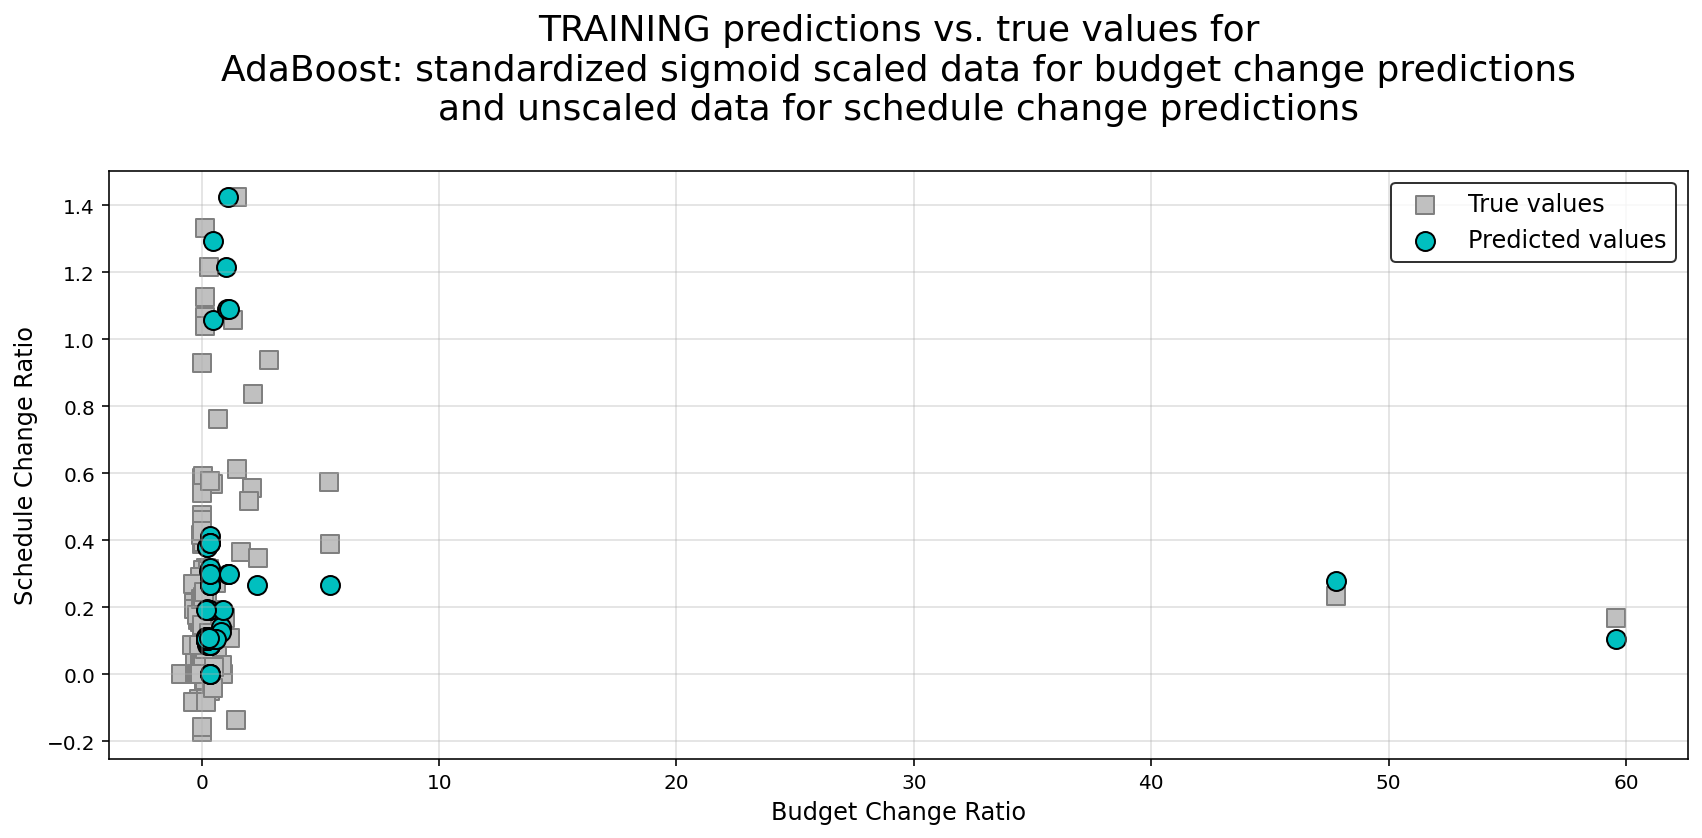

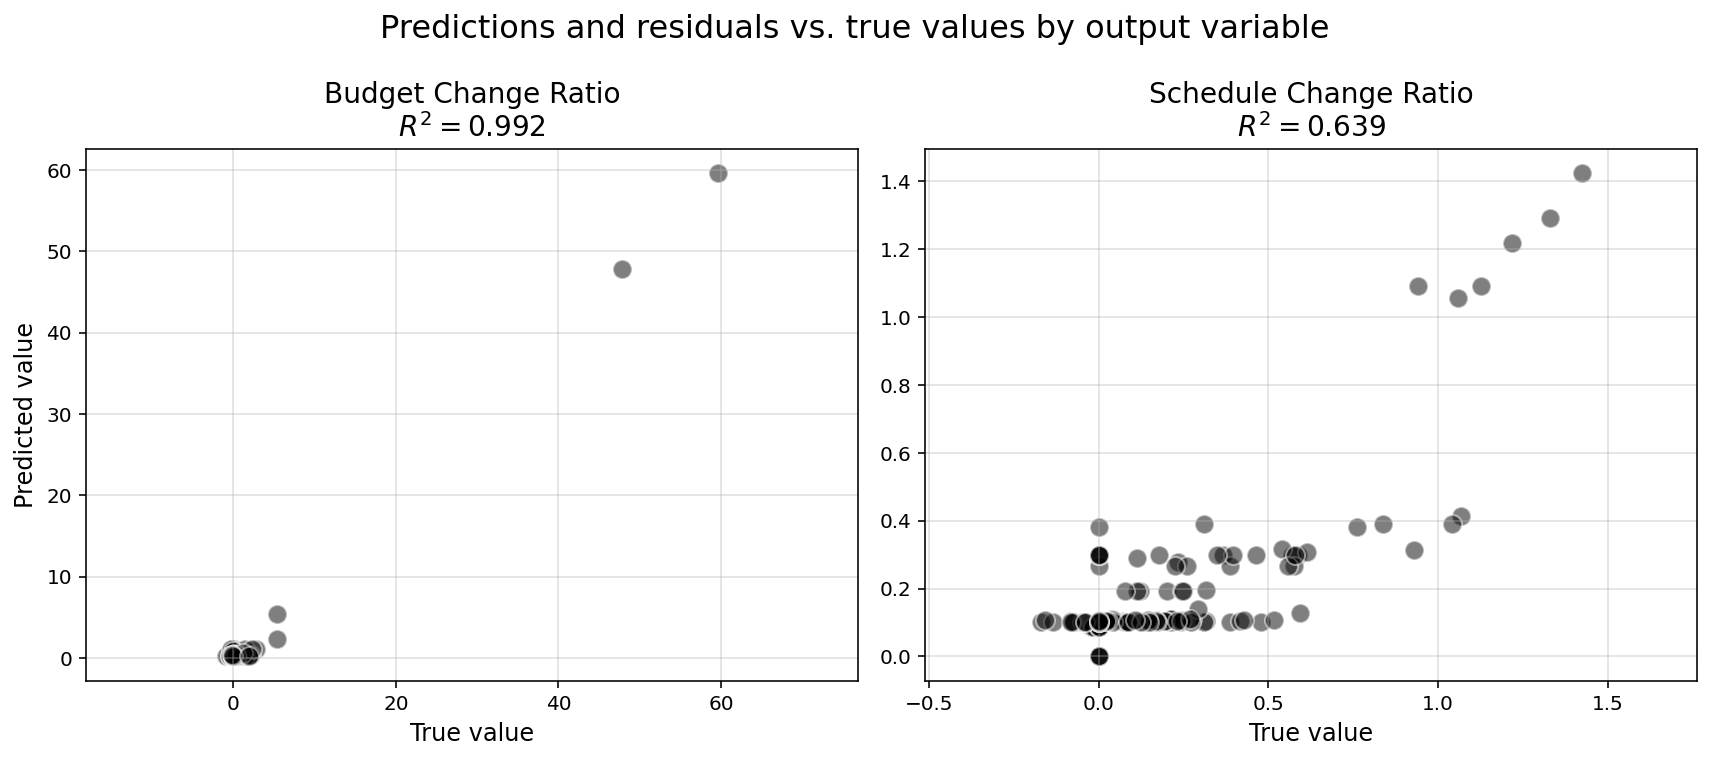

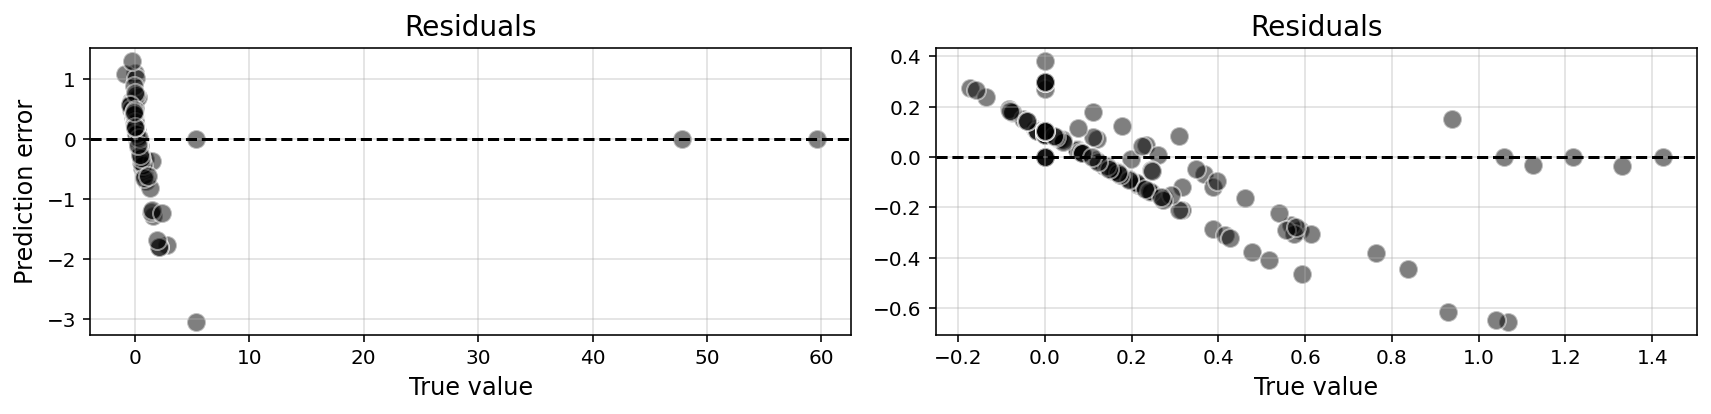

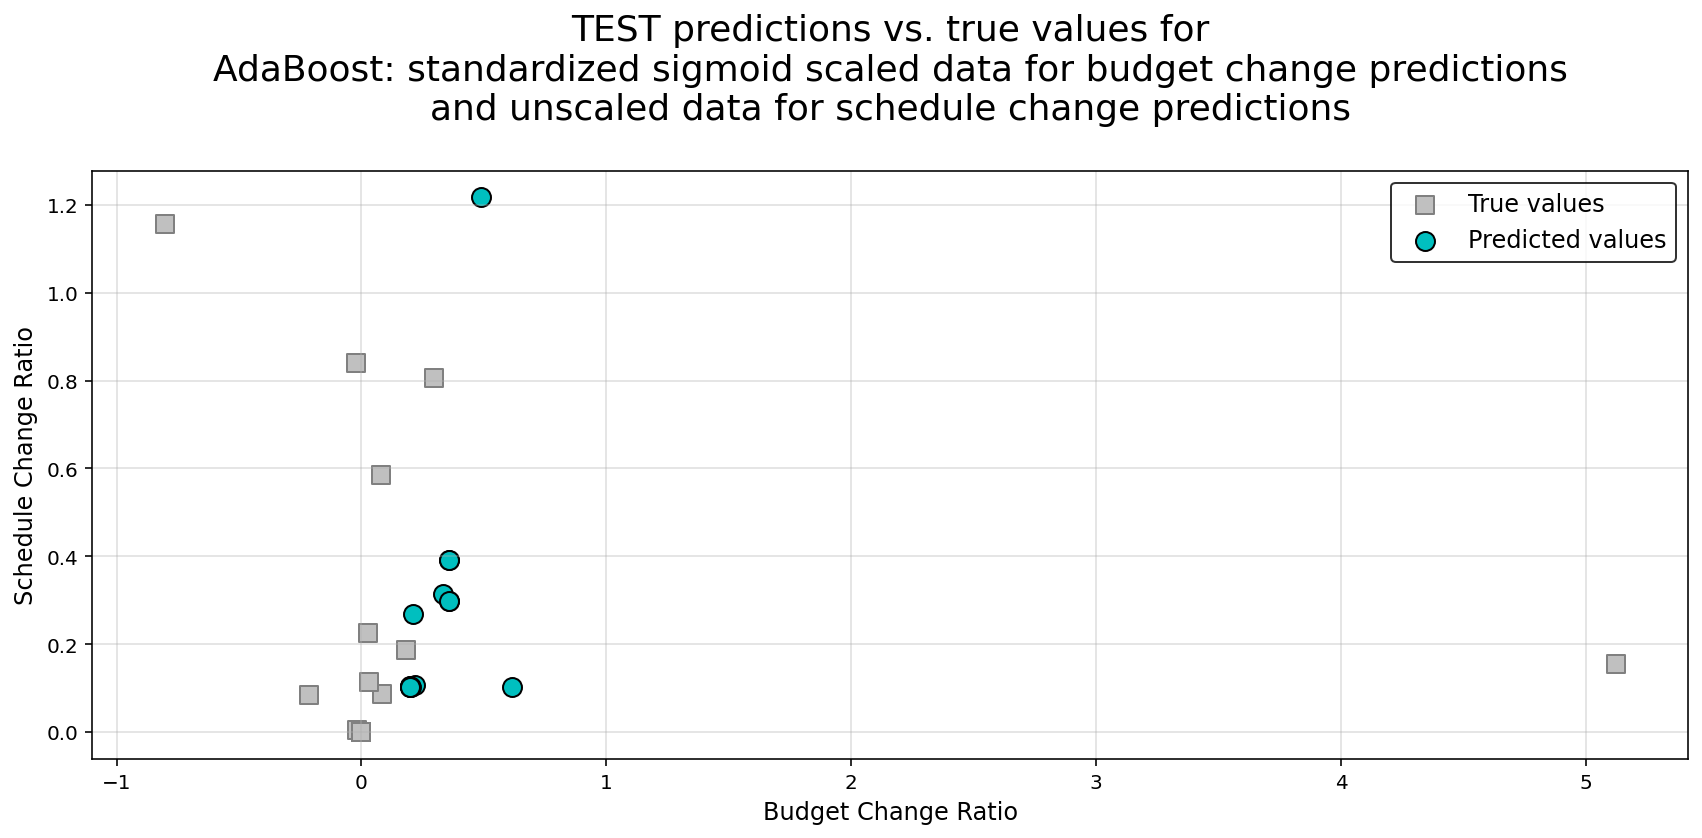

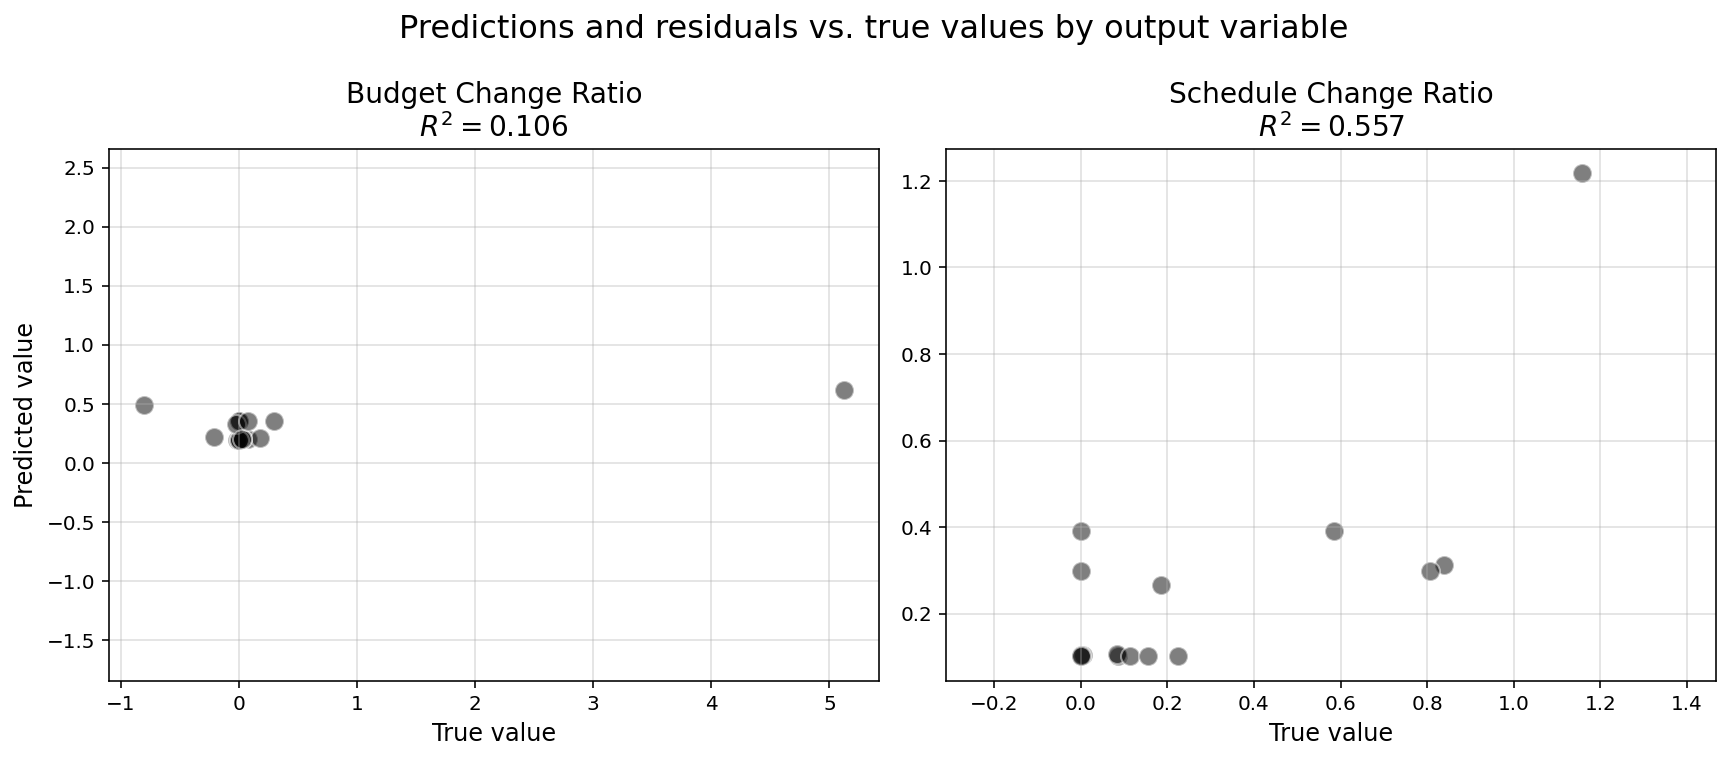

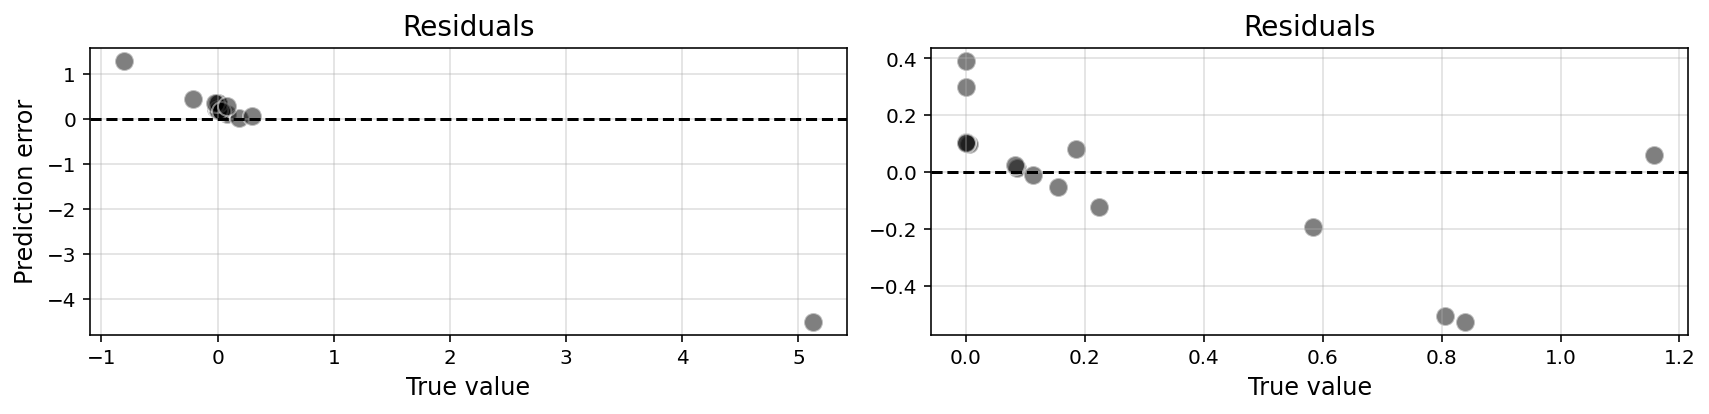

In [20]:
model_descr = 'AdaBoost: standardized sigmoid scaled data for budget change predictions\n'\
              'and unscaled data for schedule change predictions'
y1_label = 'Budget Change Ratio'
y2_label = 'Schedule Change Ratio'

plot_true_pred(
    dataset='train',
    y_true=y_train,
    y_pred=y_pred_train,
    y1_label=y1_label,
    y2_label=y2_label,
    model_descr=model_descr
)
plot_true_pred(
    dataset='test',
    y_true=y_test,
    y_pred=y_pred_test,
    y1_label=y1_label,
    y2_label=y2_label,
    model_descr=model_descr
)

<a name='results'></a>

# Examine the effects of `max_depth` and number of iterations on our results

### Note, I can access the saved fitted models directly from the generated model dicts to create the results below

<a href=#index>index</a>

#### First I create a couple of functions to:

1. **Generate AdaBoost "staged scores" at each iteration of the AdaBoost fitted algorithm**
2. **Plot those staged scores for each `y` variable for both training and test**

In [21]:
def generate_adaboost_staged_scores(model_dict, X_train, X_test, y_train, y_test):
    """Generates adaboost staged scores in order to find ideal number of iterations
    
    :return: tuple of 2D np.arrays for adaboost staged scores at each iteration and
             each response variable, one array for training scores and one for test 
    """
    staged_scores_train = np.hstack(
        [
            np.array(
                list(
                    model.staged_score(
                        X_train.reset_index(drop=True),
                        y_train.reset_index(drop=True).iloc[:, i]
                    )
                )
            ).reshape(-1,1) for i, model in enumerate(model_dict['model'])
        ]
    )
    
    staged_scores_test = np.hstack(
        [
            np.array(
                list(
                    model.staged_score(
                        X_test.reset_index(drop=True),
                        y_test.reset_index(drop=True).iloc[:, i]
                    )
                )
            ).reshape(-1,1) for i, model in enumerate(model_dict['model'])
        ]
    )
    
    return staged_scores_train, staged_scores_test


def plot_adaboost_staged_scores(model_dict, X_train, X_test, y_train, y_test):
    """Plots the adaboost staged scores for each y variable's predictions and iteration
    
    """
    # generate staged_scores
    training_scores, test_scores = generate_adaboost_staged_scores(
        model_dict, X_train, X_test, y_train, y_test
    )
    
    max_depth = model_dict['model'][0].base_estimator.max_depth
    learning_rate = model_dict['model'][0].learning_rate
    y_vars = [var.replace('_', ' ') for var in model_dict['y_variables']]

    # create list of iteration numbers for plotting
    iteration_numbers = np.arange(model_dict['model'][0].n_estimators) + 1

    # plot figure
    fig, ax = plt.subplots(figsize=(12, 8))

    plt.title(
        "Number of iterations' effect on the AdaBoost Regessor's\nperformance "\
        "with max depth {} and learning rate {}".format(
            max_depth,
            learning_rate,
        ),
        fontsize=18,
    )

    ax.plot(
        iteration_numbers, training_scores[:, 0],
        color='k', linestyle='--', linewidth=2,
        label='{}, training'.format(y_vars[0]))

    ax.plot(
        iteration_numbers, test_scores[:, 0],
        color='k', linestyle='-', linewidth=2,
        label='{}, TEST'.format(y_vars[0]))

    ax.plot(
        iteration_numbers, training_scores[:, 1],
        color='silver', linestyle='--', linewidth=2,
        label='{}, training'.format(y_vars[1]))

    ax.plot(
        iteration_numbers, test_scores[:, 1],
        color='silver', linestyle='-', linewidth=2,
        label='{}, TEST'.format(y_vars[1]))

    ax.tick_params(labelsize=12)
    ax.set_ylabel("$R^2$ score", fontsize=16)
    ax.set_xlabel("number of adaboost iterations", fontsize=16)
    ax.set_xticks(iteration_numbers)
    ax.grid(':', alpha=0.4)
    ax.legend(fontsize=12, edgecolor='k')

    plt.tight_layout()
    plt.show();

### Next I generate a couple of new `AdaBoostRegressor` model dictionaries, each with a different `max_depth`, both using the unscaled data

In [22]:
model_descr = 'AdaBoost tree ensemble unscaled data with max depth of 3'

# set parameters for AdaBoostRegressor model object
max_depth = 3
learning_rate = 0.05
n_estimators = 40
random_state = 109


model_ada_unscaled_3 = generate_model_dict(
    AdaBoostRegressor,
    model_descr,
    X_train[features], X_test[features], y_train, y_test,
    multioutput=False,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn',
    # these parameters below will be passed as *kwargs,
    # which means they will feed directly to the model object
    # when it is initialized
    base_estimator=DecisionTreeRegressor(
        max_depth=max_depth, random_state=random_state
    ),
    learning_rate = learning_rate,
    n_estimators = n_estimators,
    random_state=random_state
)

print_model_results(model_ada_unscaled_3)

model_descr = 'AdaBoost tree ensemble unscaled data with max depth of 5'

max_depth = 5

model_ada_unscaled_5 = generate_model_dict(
    AdaBoostRegressor,
    model_descr,
    X_train[features], X_test[features], y_train, y_test,
    multioutput=False,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn',
    # these parameters below will be passed as *kwargs,
    # which means they will feed directly to the model object
    # when it is initialized
    base_estimator=DecisionTreeRegressor(
        max_depth=max_depth, random_state=random_state
    ),
    learning_rate = learning_rate,
    n_estimators = n_estimators,
    random_state=random_state
)

print_model_results(model_ada_unscaled_5)



MODEL SUMMARY:
AdaBoost tree ensemble unscaled data with max depth of 3


The fitted model object(s):

	AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       rando

### Lastly, I plot the staged scores from each model to inspect the effect of `max_depth` and `n_estimators` (i.e number of iterations) on our `AdaBoostRegressor` model

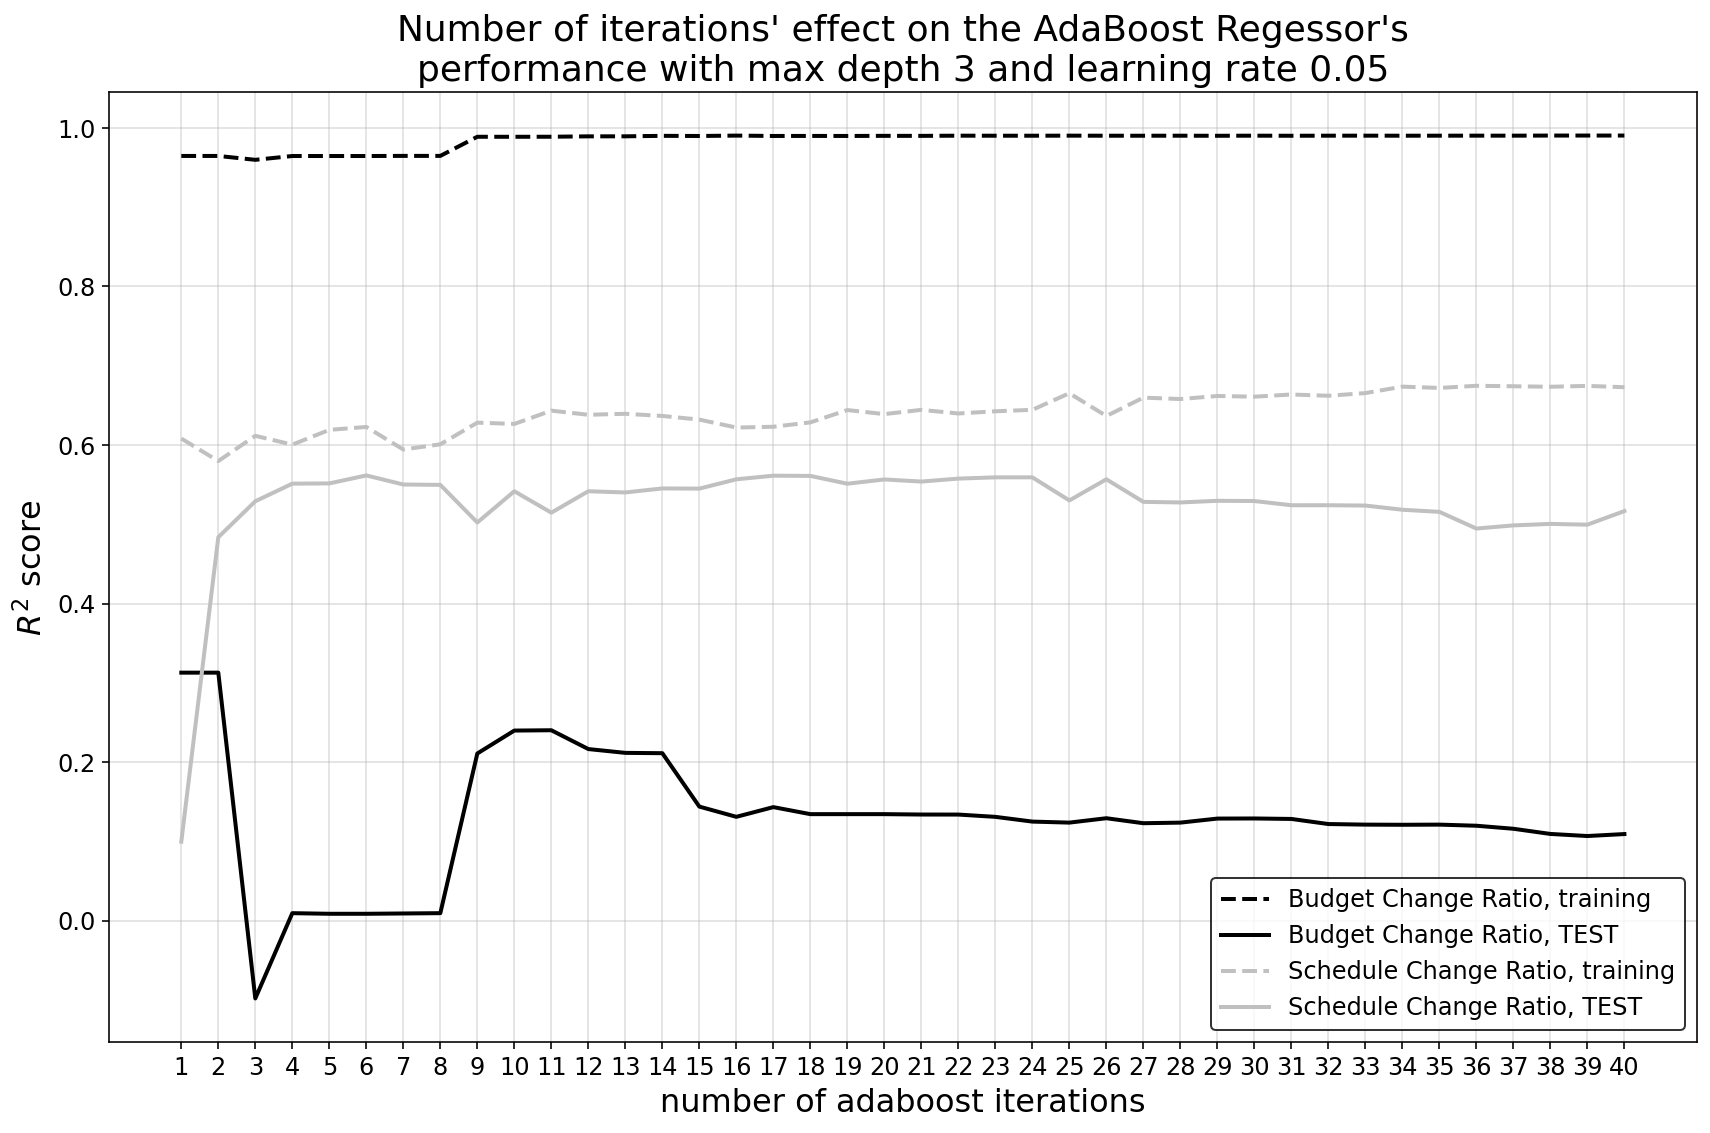

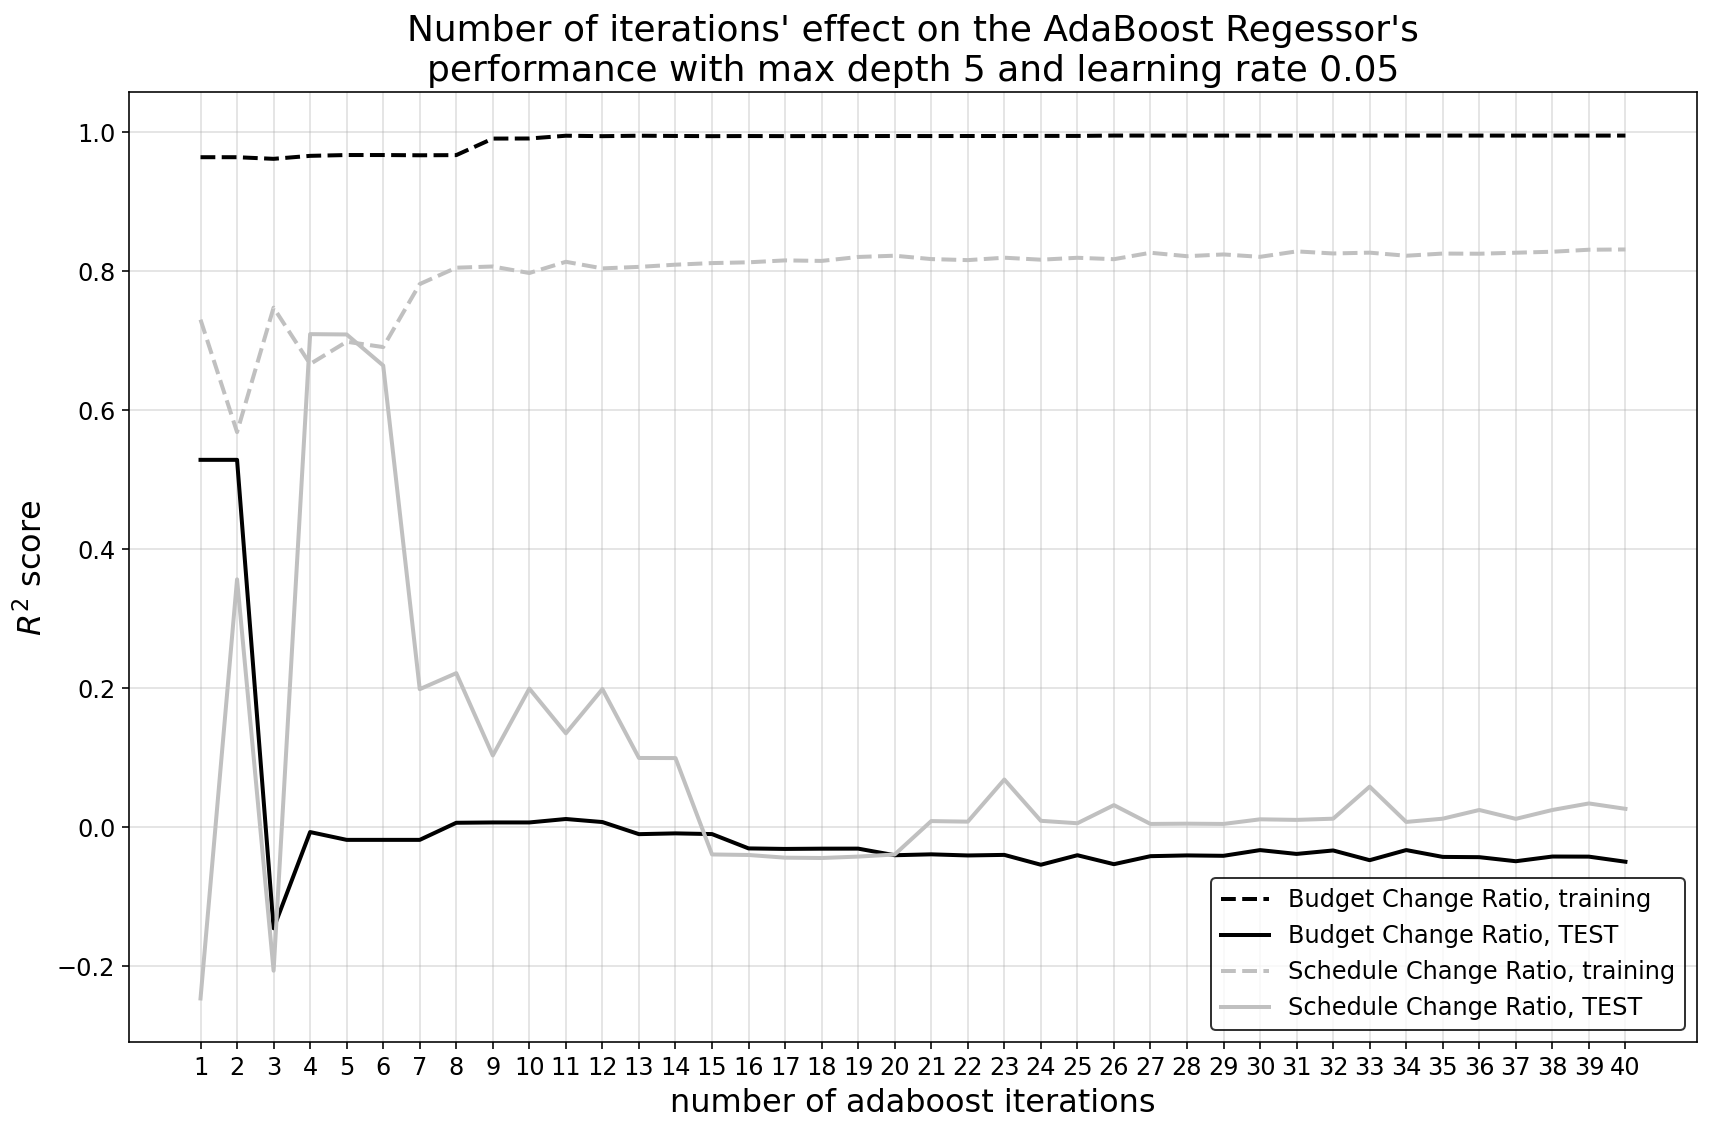

In [23]:
plot_adaboost_staged_scores(model_ada_unscaled_3, X_train, X_test, y_train, y_test)
plot_adaboost_staged_scores(model_ada_unscaled_5, X_train, X_test, y_train, y_test)

<a name='findings'></a>


# Findings:

<a href=#index>index</a>

Based on these results, it looks like increasing `max_depth` of our AdaBoost model's underlying `DecisionTreeRegressor` from 3 to 5 may possibly increase the predictive accuracy of our model for both `Budget_Change_Ratio` AND `Schedule_Change_Ratio` TEST predictions. However, the increased `max_depth` does look a little bit more unstable.

Also, it appears that different numbers of iterations (i.e. `n_estimators` parameters) for both sets of predictions will gain us improvements in $R^2$ scores for `Budget_Change_Ratio` AND `Schedule_Change_Ratio` TEST predictions.

 - `n_estimators = 2` for the `Budget_Change_Ratio` model if `max_depth = 5` or `max_depth = 3` 
 - `n_estimators = 5` for the `Schedule_Change_Ratio` model if `max_depth = 5` or `max_depth = 3`
 
**However, I think we'd want to conduct a true cross-validated grid search to arrive at these conclusions using only our training data with cross-validation to pick both our best `max_depth` and `n_estimators` parameters. Not by looking directly at our training results as I have done above, as I am sure a different train/test split will provide very different results.**

**If we are able to replicate these results using cross-validation, it means we can potentially achieve $R^2$ scores grater than 0.50 for both our `Budget_Change_Ratio` AND `Schedule_Change_Ratio` TEST predictions using only `Budget_Start`, `Duration_Start`, and `Category` as our predictors.**